We have an explicit scheme:

$$ \frac{u^{n+1}_i - u^n_i}{\Delta t} + \frac{c}{\Delta x}(u^n_i - u^n_{i-1}) = 0 $$

This is transposed in order to get the future point $u^{n+1}_i$ in terms of the past points, $u^n_i$ and $u^n_{i-1}$:

$$ u^{n+1}_i = u^n_i - \frac{c \Delta t}{\Delta x}(u^n_i - u^n_{i-1}) $$

We use a BTCS scheme:

$$ u_{i,\,j} = u_{i,\,j-1} - \frac{c \Delta t}{2 \Delta x}(u_{i+1,\,j} - u_{i-1,\,j}) $$

But this scheme requires the simultaneous calculation of $u$ at all nodes on the $j$ mesh line. So we form a system of linear equations:

$$ u_{i,\,j-1} = u_{i,\,j} + \left[\frac{c \Delta t}{2 \Delta x}\right] u_{i+1,\,j} - \left[\frac{c \Delta t}{2 \Delta x}\right] u_{i-1,\,j} \qquad \forall i \in [1, N_x-1) $$

*Note: $u_{i,\,j-1}$ is from the previous time-step and so we always know it.*

With proper ordering, substitution of $\mathrm{CFL}$, and use of constants $a,b,c$, we have:

$$ u_{i,\,j-1} = \underbrace{-\left[\frac{c \Delta t}{2 \Delta x}\right]}_{a = -\mathrm{CFL}/2} \cdot u_{i-1,\,j} + \underbrace{1}_{b = 1} \cdot u_{i,\,j} + \underbrace{\left[\frac{c \Delta t}{2 \Delta x}\right]}_{c = +\mathrm{CFL}/2} \cdot u_{i+1,\,j}  \qquad \forall i \in [1, N_x-1) $$

$$ u_{i,\,j-1} = a \cdot u_{i-1,\,j} + b \cdot u_{i,\,j} + c \cdot u_{i+1,\,j}  \qquad \forall i \in [1, N_x-1) $$


Expanding the above expression for all values of $i$:

$$
a\ u_{0,\,j} + b\ u_{1,\,j} + c\ u_{2,j} = u_{1,\,j-1} \\
a\ u_{1,\,j} + b\ u_{2,\,j} + c\ u_{3,j} = u_{2,\,j-1} \\
\vdots \\
a\ u_{38,\,j} + b\ u_{39,\,j} + c\ u_{40,j} = u_{39,\,j-1}
$$

In matrix form, this system of linear equations is:

$$
\mathbf{A}\mathbf{x} = \mathbf{b} \\
\\
x = \begin{bmatrix}
u_{0,\,j} \\
u_{1,\,j} \\
\vdots \\
u_{40,\,j} \\
\end{bmatrix} \\
b = \begin{bmatrix}
u_{0,\,j-1} \\
u_{1,\,j-1} \\
\vdots \\
u_{40,\,j-1} \\
\end{bmatrix} \\
A = \begin{bmatrix}
a & b & c & 0 & 0 & \cdots & 0 & 0 & 0 & 0 \\
0 & a & b & c & 0 & \cdots & 0 & 0 & 0 & 0 \\
0 & 0 & a & b & c & \cdots & 0 & 0 & 0 & 0 \\
  &   &   &   &   & \ddots &   &   &   &   \\
0 & 0 & 0 & 0 & 0 & \cdots & b & c & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & \cdots & a & b & c & 0 \\
0 & 0 & 0 & 0 & 0 & \cdots & 0 & a & b & c \\
\end{bmatrix}
$$

But this is a $39 \times 41$ matrix. We cannot solve a system of 41 unknowns with 39 equations. To do that, we use 2 more equations for the boundary conditions:

$$
\begin{align*}
u_{0,\,j} &= 1 \\
\underbrace{(-\mathrm{CFL})}_{2a} \cdot u_{39,\,j} + \underbrace{(1+\mathrm{CFL})}_{1+2c} \cdot u_{40,\,j} &= u_{40,\,j-1}
\end{align*}
$$

Giving us an expanded $41 \times 41$ matrix:
$$
A = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & \cdots & 0 & 0 & 0 & 0 \\
a & b & c & 0 & 0 & \cdots & 0 & 0 & 0 & 0 \\
0 & a & b & c & 0 & \cdots & 0 & 0 & 0 & 0 \\
0 & 0 & a & b & c & \cdots & 0 & 0 & 0 & 0 \\
  &   &   &   &   & \ddots &   &   &   &   \\
0 & 0 & 0 & 0 & 0 & \cdots & b & c & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & \cdots & a & b & c & 0 \\
0 & 0 & 0 & 0 & 0 & \cdots & 0 & a & b & c \\
0 & 0 & 0 & 0 & 0 & \cdots & 0 & 0 & 2a & 1\!+\!2c \\
\end{bmatrix}
$$

In [1]:
## Set up constants.
xmax = 2.0
wave_vel = 1.0  # `C' in equations
cfl = 2.0
nx, nt = 41, 10

dx = xmax/(nx-1)
dt = cfl*dx/wave_vel
tmax = dt*nt

In [2]:
import numpy as np 

np.set_printoptions(threshold=np.inf) #, precision=2)

## Note: We use three different conventions from the hints.
##   1. There, a and b are swapped.
##   2. ourMatrix[i][i] = hintMatrix[-i-1][-j-1]
##   3. Arrays are 0-indexed in both the notes and code, rather than 1-indexed as in the hint.
def construct_matA(cfl, nx, return_diags=False):
    a = np.array([-cfl/2.0 for i in range(nx)])  # sub diagonal
    b = np.array([1.0 for i in range(nx)])       # main diagonal
    c = np.array([+cfl/2.0 for i in range(nx)])  # super diagonal

    b[0] = 1.0     # a_41 in the hint
    c[0] = 0.0
    b[-1] = 1+cfl  # a_1 in the hint
    a[-1] = -cfl   # b_41 in the hint
        
    matA = np.zeros((nx,nx))

    for i in range(nx):
        matA[i,i] = b[i]
        if i > 0:
            matA[i,i-1] = a[i]
        if i+1 < nx:
            matA[i,i+1] = c[i]
    
    if return_diags:
        return (matA, a, b, c)
    else:
        return matA


In [3]:
## NOTE: THIS IS A SOLUTION USING GENERALISED TECHNIQUES. IT IS NOT OPTIMISED FOR THE APPLICATION.
##       BUT IT WORKS.

import scipy.linalg
import matplotlib.pyplot as plt
from pprint import pprint
from timeit import default_timer as timer

plot_state = False  ## NOTE: CHANGE THIS TO GET PLOTS OF EACH TIMESTEP
start = timer()

## Note: i indexes space-steps, j indexes time-steps.
## u(i, j=0) = initial condition at time t=0
x = np.linspace(0.0, xmax, num=nx)
u = np.array([1.0 if x[i] <= 0.5 else 2.0 for i in range(nx)])

matA = construct_matA(cfl=cfl, nx=nx, return_diags=False)
_, L, U = scipy.linalg.lu(matA, permute_l=False)
Linv, Uinv = scipy.linalg.inv(L), scipy.linalg.inv(U)

y = np.zeros(nx)
x = np.zeros(nx)

def print_state(plot_state, u, f=None):
    '''Print current state: u_j (Note: j = 0..40; including initial condition)'''
    if plot_state:
        plt.plot(u)
        plt.show()
    else:
        print(','.join(str(x) for x in u), file=f)

with open(f'u_{nt}.csv', mode='w') as f:
    ## Print initial condition: u_0
    print_state(plot_state, u, f)

    ## Solve for u_j from u_{j-1} for each timestep j=1..10 (0 is the initial condition)
    for j in range(nt):
        np.matmul(Linv, u, out=y)
        np.matmul(Uinv, y, out=x)
        u = x
        print_state(plot_state, u, f)

pprint(matA)
pprint(u)

end = timer()
print("Running time:", end - start)

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [-1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0., -1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0., -1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0., -1.,  1.,  1.,  0.,  0., 

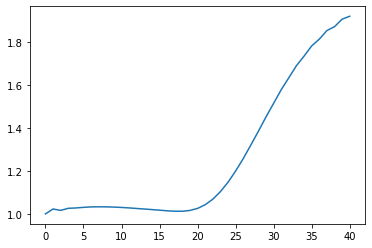

In [4]:
## Plot the state of u_10: the result of the last time-step.
print_state(True, u)

## NOTE: THE FOLLOWING CODE DOES NOT WORK. TRY THE GENERAL SOLUTION ABOVE ONLY.
```

import scipy.linalg
import matplotlib.pyplot as plt
from pprint import pprint

## Note: i indexes space-steps, j indexes time-steps.
## u(i, j=0) = initial condition at time t=0
x = np.linspace(0.0, xmax, num=nx)
u = np.array([1.0 if x[i] <= 0.5 else 2.0 for i in range(nx)])

def construct_LU(e, f):
    '''For debugging purposes.'''
    L = np.zeros((nx,nx))
    U = np.zeros((nx,nx))
    for i in range(nx):
        L[i,i] = 1.0
        if i > 0:
            L[i,i-1] = e[i]
        U[i,i] = f[i]
        if i+1 < nx:
            U[i,i+1] = c[i]
    return (L, U)

def LU_tridiagonal_decomposition(matA):
    '''Run SciPy's generalised LU decomposition. (Not specific to tridiagonal matrices.)'''
    _, L, U = scipy.linalg.lu(matA, permute_l=False)
    print(f'L=\n{L}')
    print(f'U=\n{U}')

    e = np.zeros(nx)
    f = np.zeros(nx)
    f[0] = U[0][0]
    for i in range(1, nx):
        e[i] = L[i,i-1]
        f[i] = U[i,i]
    return (e, f)

def LU_tridiagonal_decomposition_tri(a, b, c):
    '''Run an optimised LU decomposition algorithm for tridiagonal matrices.'''
    e = np.zeros(nx)
    f = np.zeros(nx)
    f[0] = b[0]
    for i in range(1, nx):
        e[i] = a[i] / f[i-1]
        f[i] = b[i] - e[i]*c[i-1]
    return (e, f)

def forward_substitution(d, e):
    '''Forward substitution: Solve Ly = d, for y. We take d(i) = u(i, j-1) meaning d(i) is u(i) in prev timestep.'''
    y = np.zeros(nx)
    y[0] = d[0]
    for i in range(1, nx):
        y[i] = d[i] - e[i]*y[i-1]
    return y

def backward_substitution(y, f, c):
    '''Backward substitution: Solve Ux = y, for x'''
    x = np.zeros(nx)
    x[-1] = y[-1]/f[-1]
    for i in range(nx-2, -1, -1): 
        x[i] = (y[i] - c[i]*y[i+1])/f[i]
    return x

matA, a, b, c = construct_matA(cfl=cfl, nx=nx, return_diags=True)
# e, f = LU_tridiagonal_decomposition_tri(a, b, c)
e, f = LU_tridiagonal_decomposition(matA=matA)

# print('--------------------')
print(f'{e=}')
print(f'{f=}')
# print('--------------------')
# L, U = construct_LU(e, f)
# print(f'LU=\n{np.matmul(L, U)}')
# print('--------------------')

## Perform BTCS for nt timesteps
for j in range(nt):
    y = forward_substitution(u, e)
    x = backward_substitution(y, f, c)
    u = x
    # if j%1 == 0:
    #     plt.plot(u)
    #     plt.show()

pprint(u)